In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import f1_score, accuracy_score

In [3]:
file_path = 'data\sample.wav'
audio_data, sample_rate = librosa.load(file_path, sr=None)
audio_array = np.array(audio_data)

print("Размерность массива:", audio_array.shape)
print(f"Частота дискретизации: {sample_rate} Гц")

Размерность массива: (140928,)
Частота дискретизации: 44100 Гц


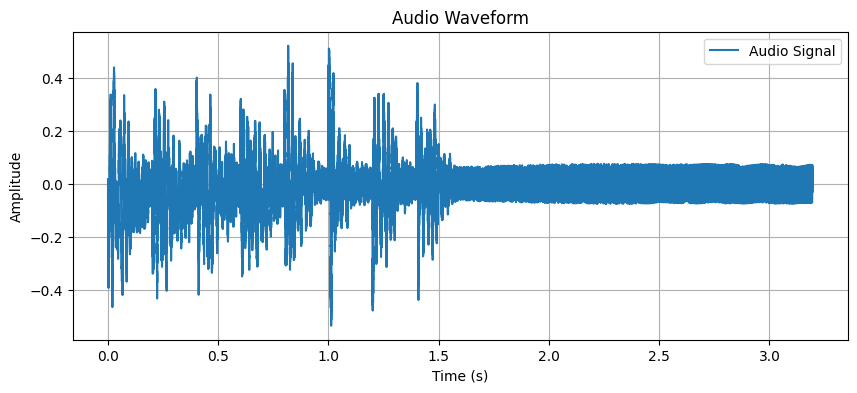

In [4]:
time = np.linspace(0, len(audio_array) / sample_rate, num=len(audio_array))

# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(time, audio_array, label='Audio Signal')
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

### [ESC-50: Dataset for Environmental Sound Classification](https://github.com/karolpiczak/ESC-50)

In [8]:
class ESC50Dataset(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.classes = sorted(self.annotations['category'].unique())  # Сортируем классы для единообразия
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Получаем путь к файлу
        audio_sample_path = os.path.join(self.audio_dir, self.annotations.iloc[idx]['filename'])
        label_name = self.annotations.iloc[idx]['category']  # Категория
        label = self.class_to_idx[label_name]  # Преобразуем в индекс
        
        # Читаем аудиофайл
        waveform, sr = librosa.load(audio_sample_path, sr=None, mono=True)
        
        # Применяем трансформацию
        if self.transform:
            waveform = self.transform(audio_sample_path)  # Передаем путь, не waveform

        return waveform, torch.tensor(label, dtype=torch.long)

    def get_class_labels(self):
        return self.class_to_idx

In [9]:
class AudioTransform:
    def __init__(self, sr=16000, n_mels=128, n_fft=1024, hop_length=512):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

    def __call__(self, file_path):
        waveform, orig_sr = librosa.load(file_path, sr=None, mono=True)  # Загружаем аудио
        if orig_sr != self.sr:
            waveform = librosa.resample(waveform, orig_sr=orig_sr, target_sr=self.sr)  # Ресемплинг
            
        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
        )
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Преобразование в dB

        log_mel_spectrogram = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)  # [1, n_mels, time]
        return log_mel_spectrogram

In [10]:
# Data preparation
csv_file = 'data/ESC-50-master/meta/esc50.csv'
audio_dir = 'data/ESC-50-master/audio'
transform = AudioTransform()

dataset = ESC50Dataset(csv_file=csv_file, audio_dir=audio_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
num_classes = len(dataset.classes)
sample_waveform, _ = dataset[0]
input_shape = sample_waveform.shape
print(input_shape)
num_classes

torch.Size([1, 128, 157])


50

In [12]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Model, loss function, and optimizer
model = AudioClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, "
              f"Train Accuracy: {train_accuracy}, Train F1 Score: {train_f1}")

        # Evaluation
        model.eval()
        val_labels = []
        val_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f"Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}")

# Train and evaluate the model
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Loss: 3.5620358276367186, Train Accuracy: 0.105625, Train F1 Score: 0.07631557081738542
Validation Accuracy: 0.1825, Validation F1 Score: 0.1012258793387786
Epoch 2/20, Loss: 3.1568522596359254, Train Accuracy: 0.188125, Train F1 Score: 0.14326342510998447
Validation Accuracy: 0.1425, Validation F1 Score: 0.10064674772929244
Epoch 3/20, Loss: 2.910596933364868, Train Accuracy: 0.228125, Train F1 Score: 0.19310925911594154
Validation Accuracy: 0.25, Validation F1 Score: 0.2004847495118388
Epoch 4/20, Loss: 2.7117529249191286, Train Accuracy: 0.29625, Train F1 Score: 0.258621977385158
Validation Accuracy: 0.29, Validation F1 Score: 0.22366569851702942
Epoch 5/20, Loss: 2.531585168838501, Train Accuracy: 0.34125, Train F1 Score: 0.3103008254615169
Validation Accuracy: 0.255, Validation F1 Score: 0.20059790752062068
Looking in indexes: https://download.pytorch.org/whl/cu118
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\phyton\\Lib\\site-packages\\~=rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



Epoch 6/20, Loss: 2.411655168533325, Train Accuracy: 0.369375, Train F1 Score: 0.3388092797472046
Validation Accuracy: 0.2475, Validation F1 Score: 0.2036731450199646
Epoch 7/20, Loss: 2.278697082996368, Train Accuracy: 0.391875, Train F1 Score: 0.3585045569595391
Validation Accuracy: 0.3225, Validation F1 Score: 0.2851619945154927
Epoch 8/20, Loss: 2.2182276248931885, Train Accuracy: 0.41125, Train F1 Score: 0.3906025727196573
Validation Accuracy: 0.355, Validation F1 Score: 0.30685280334830156
Epoch 9/20, Loss: 2.096590802669525, Train Accuracy: 0.44625, Train F1 Score: 0.4176933292865106
Validation Accuracy: 0.335, Validation F1 Score: 0.2971819893705936
Epoch 10/20, Loss: 1.9932289767265319, Train Accuracy: 0.46875, Train F1 Score: 0.45153903263820333
Validation Accuracy: 0.3275, Validation F1 Score: 0.27945954172735776
Epoch 11/20, Loss: 1.923963131904602, Train Accuracy: 0.474375, Train F1 Score: 0.45693520655256026
Validation Accuracy: 0.315, Validation F1 Score: 0.2737242171548